In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score
import warnings
import ast
import re


warnings.filterwarnings('ignore')

url = "C:/Users/Nimrod/Documents/mid_projects_tests/flo_data_20k.csv"

df = pd.read_csv(url)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

## Checking for na's & duplicates

In [3]:
df.isna().any()

master_id                            False
order_channel                        False
last_order_channel                   False
first_order_date                     False
last_order_date                      False
last_order_date_online               False
last_order_date_offline              False
order_num_total_ever_online          False
order_num_total_ever_offline         False
customer_value_total_ever_offline    False
customer_value_total_ever_online     False
interested_in_categories_12          False
dtype: bool

In [4]:
df.duplicated().any()

False

## Data Cleaning 

### Numerical columns

In [5]:
num_df = df.select_dtypes(include='number')

num_df['total_num_orders'] = num_df['order_num_total_ever_online'] + num_df['order_num_total_ever_offline']
num_df['customer_total_value'] = num_df['customer_value_total_ever_offline'] + num_df['customer_value_total_ever_online']

In [6]:
num_df = num_df.drop(['order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online'], axis=1)

num_df

,total_num_orders,customer_total_value
0,5.0,939.37
1,21.0,2013.55
2,5.0,585.32
3,2.0,121.97
4,2.0,209.98
...,...,...
19940,3.0,401.96
19941,2.0,390.47
19942,3.0,632.94
19943,6.0,1009.77


## Date Columns 

### Converting to date type 


In [7]:
date_df = df[['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline']]

date_df

,first_order_date,last_order_date,last_order_date_online,last_order_date_offline
0,2020-10-30,2021-02-26,2021-02-21,2021-02-26
1,2017-02-08,2021-02-16,2021-02-16,2020-01-10
2,2019-11-27,2020-11-27,2020-11-27,2019-12-01
3,2021-01-06,2021-01-17,2021-01-17,2021-01-06
4,2019-08-03,2021-03-07,2021-03-07,2019-08-03
...,...,...,...,...
19940,2019-09-21,2020-07-05,2020-06-05,2020-07-05
19941,2020-03-01,2020-12-22,2020-12-22,2020-03-01
19942,2019-09-11,2021-05-24,2021-05-24,2019-09-11
19943,2019-03-27,2021-02-13,2021-02-13,2021-01-08


In [8]:

for i in date_df.keys():
    date_df[i] = pd.to_datetime(date_df[i])


In [9]:
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   first_order_date         19945 non-null  datetime64[ns]
 1   last_order_date          19945 non-null  datetime64[ns]
 2   last_order_date_online   19945 non-null  datetime64[ns]
 3   last_order_date_offline  19945 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 623.4 KB


### Creation of total date coulmns

In [10]:
# needs to be calculated for both online & offline times
# now - first order date = life_time 
# now - last order date = time since last order 

# Total customer lifetime (offline?)
date_df['total_lifetime_days'] = pd.Timestamp.now() - date_df['first_order_date']
date_df['total_lifetime_days'] = date_df['total_lifetime_days'].dt.days

date_df['time_from_last_order_days'] = pd.Timestamp.now() - date_df['last_order_date']
date_df['time_from_last_order_days'] = date_df['time_from_last_order_days'].dt.days
 
# number of orders / (last_order_date - first_order_date)
# 10 / 50 
# 5 order freq rate 

In [11]:

date_df['order_freq_per_month'] = num_df['total_num_orders'] / date_df['total_lifetime_days']

In [12]:
date_df.head()


,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,total_lifetime_days,time_from_last_order_days,order_freq_per_month
0,2020-10-30,2021-02-26,2021-02-21,2021-02-26,1194,1075,0.004188
1,2017-02-08,2021-02-16,2021-02-16,2020-01-10,2554,1085,0.008222
2,2019-11-27,2020-11-27,2020-11-27,2019-12-01,1532,1166,0.003264
3,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1126,1115,0.001776
4,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1648,1066,0.001214


## Categorical Encoding


### One Hot Encoding 

In [13]:
cat_df = df['order_channel']

cat_df.unique()

array(['Android App', 'Desktop', 'Mobile', 'Ios App'], dtype=object)

In [14]:
# One Hot Encoding 
cat_df = pd.get_dummies(cat_df)


cat_df = cat_df.astype(int)

In [15]:
# Editing column names
cat_df.rename(columns=lambda i: i.lower().replace(" ", "_"), inplace=True)

In [16]:
cat_df

,android_app,desktop,ios_app,mobile
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0
...,...,...,...,...
19940,1,0,0,0
19941,0,1,0,0
19942,0,0,1,0
19943,1,0,0,0


In [17]:
print(len(df['interested_in_categories_12'][1]), "\n", df['interested_in_categories_12'][1])

32 
 [ERKEK, COCUK, KADIN, AKTIFSPOR]


In [18]:
type(df['interested_in_categories_12'][0])

str

In [19]:
df_intrest = df['interested_in_categories_12']

In [20]:
df_intrest = df_intrest.apply(lambda x: x.strip('][').split(', '))


In [21]:
type(df_intrest[0])

list

In [22]:
# Items translation dict
translations = {
    'AKTIFSPOR': 'SPORTS',
    'KADIN': 'WOMEN',
    'ERKEK': 'MEN',
    'COCUK': 'CHILDREN',
    'AKTIFCOCUK': 'CHILDREN_SPORTS',
    '':''
}

#Translate_items
df_intrest = df_intrest.apply(lambda x: [translations[item] for item in x])
# Display the after translation
df_intrest.value_counts()

interested_in_categories_12
[SPORTS]                                           3464
[WOMEN]                                            2158
[]                                                 2135
[MEN]                                              1973
[WOMEN, SPORTS]                                    1352
[MEN, SPORTS]                                      1178
[MEN, WOMEN]                                        848
[CHILDREN]                                          836
[MEN, WOMEN, SPORTS]                                775
[CHILDREN_SPORTS]                                   679
[CHILDREN, WOMEN]                                   443
[CHILDREN_SPORTS, CHILDREN]                         349
[CHILDREN_SPORTS, SPORTS]                           317
[CHILDREN, SPORTS]                                  317
[CHILDREN, WOMEN, SPORTS]                           241
[CHILDREN_SPORTS, MEN, CHILDREN, WOMEN, SPORTS]     223
[MEN, CHILDREN]                                     215
[MEN, CHILDREN, WOME

In [23]:
df_encoded = df_intrest.str.join(sep='*').str.get_dummies(sep='*')
df_encoded.rename(columns=lambda i: i.lower(), inplace=True)


In [24]:
df_encoded

,children,children_sports,men,sports,women
0,0,0,0,0,1
1,1,0,1,1,1
2,0,0,1,0,1
3,1,1,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
19940,0,0,1,1,0
19941,0,0,0,1,0
19942,0,0,0,1,0
19943,0,0,1,1,0


In [25]:
# concat - num_df ,date_df, encoded_df, cat_df

In [26]:
combined_df = pd.concat([num_df, date_df, df_encoded, cat_df], axis=1)

In [27]:
combined_df.head()

,total_num_orders,customer_total_value,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,total_lifetime_days,time_from_last_order_days,order_freq_per_month,children,children_sports,men,sports,women,android_app,desktop,ios_app,mobile
0,5.0,939.37,2020-10-30,2021-02-26,2021-02-21,2021-02-26,1194,1075,0.004188,0,0,0,0,1,1,0,0,0
1,21.0,2013.55,2017-02-08,2021-02-16,2021-02-16,2020-01-10,2554,1085,0.008222,1,0,1,1,1,1,0,0,0
2,5.0,585.32,2019-11-27,2020-11-27,2020-11-27,2019-12-01,1532,1166,0.003264,0,0,1,0,1,1,0,0,0
3,2.0,121.97,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1126,1115,0.001776,1,1,0,0,0,1,0,0,0
4,2.0,209.98,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1648,1066,0.001214,0,0,0,1,0,0,1,0,0


## Data Distrabution


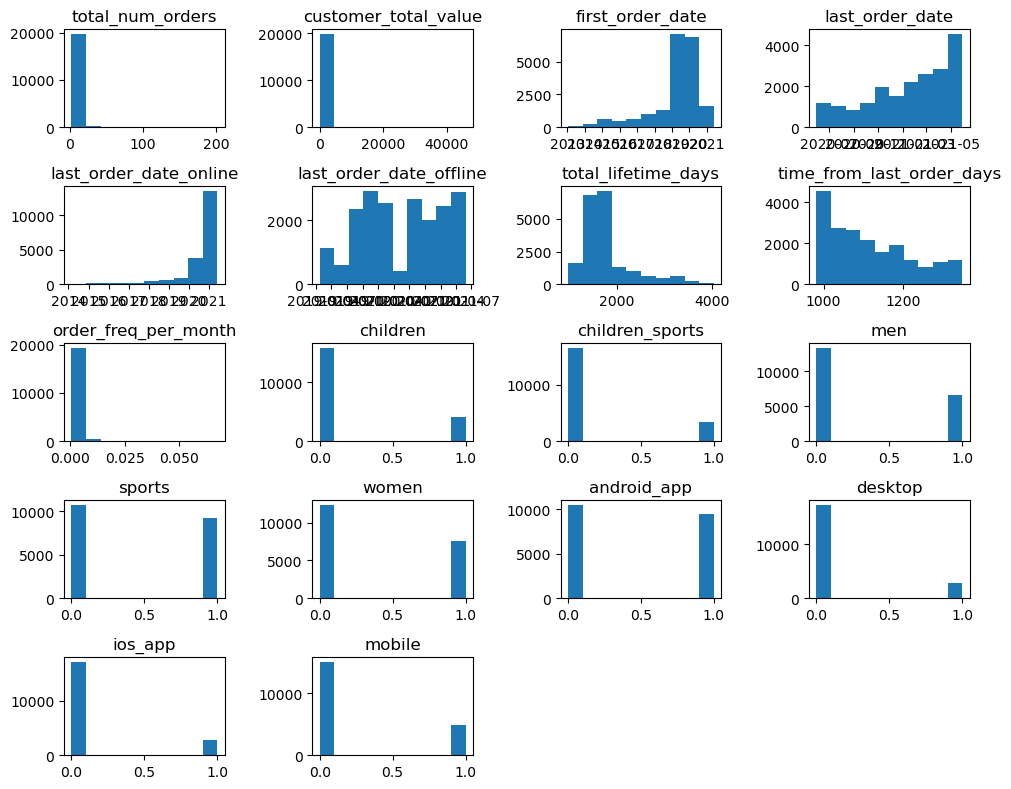

In [28]:
combined_df.hist(figsize=(10,8), grid=False)
plt.tight_layout()

<Axes: >

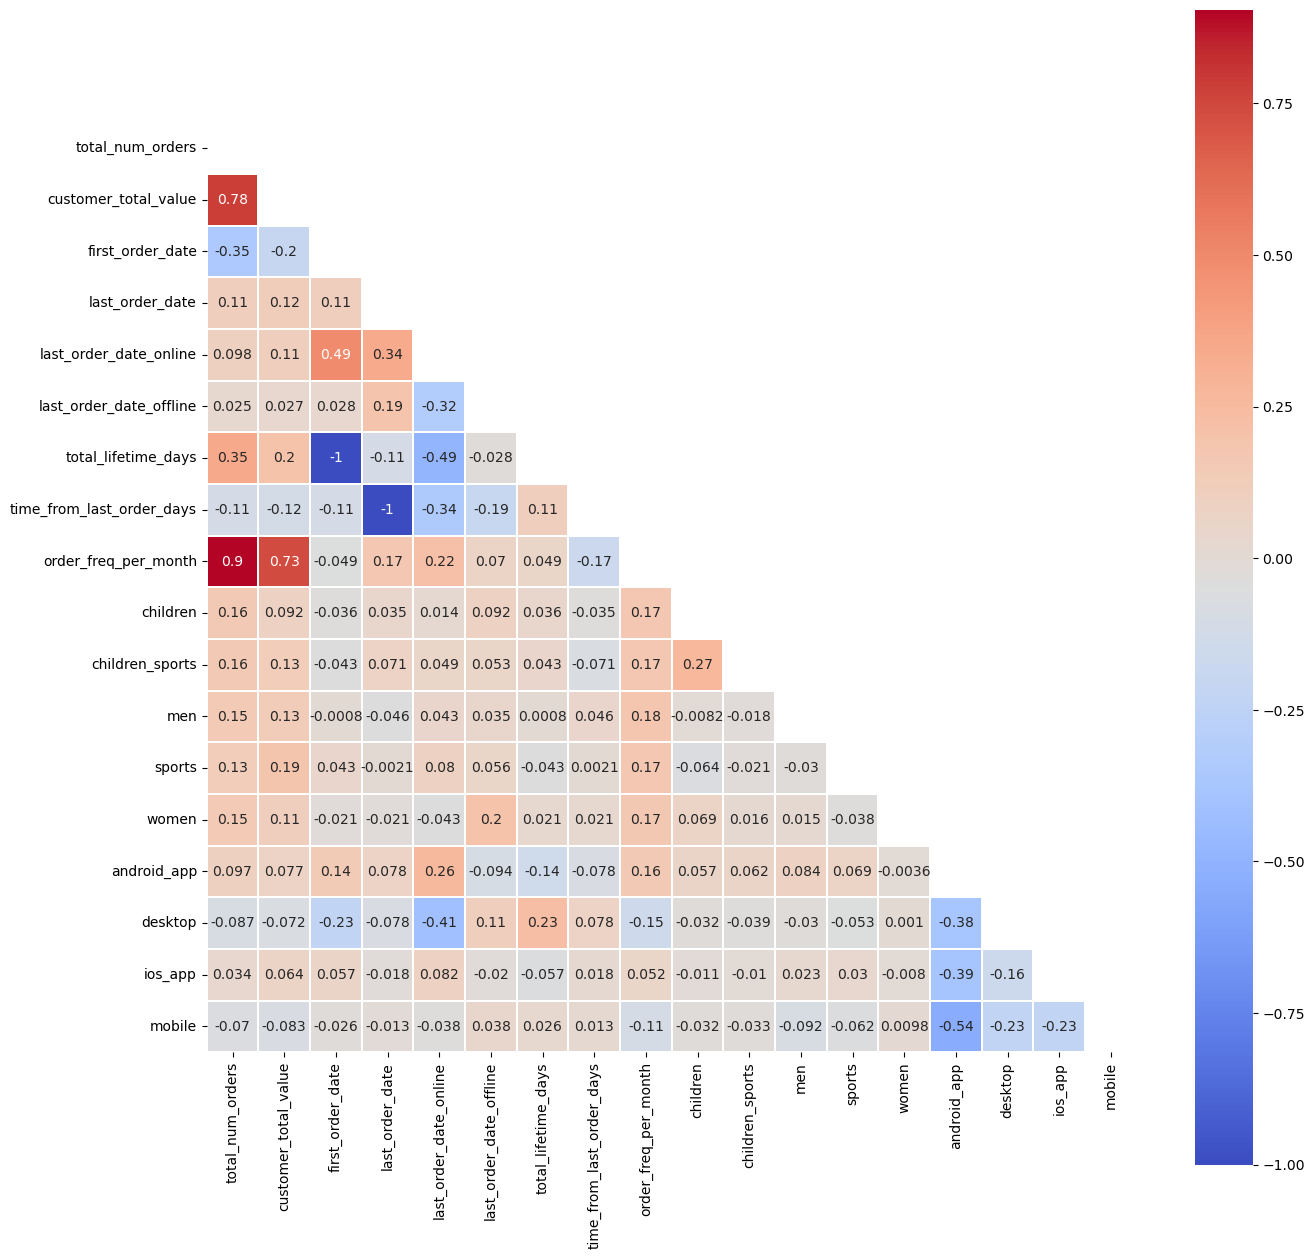

In [29]:
corr = combined_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True, mask=mask , cmap='coolwarm', square=True, linewidth=.2)

## Data splitting 

In [30]:
to_drop = ['customer_total_value', 'first_order_date','last_order_date', 'last_order_date_online', 'last_order_date_offline']

X = combined_df.drop(to_drop, axis=1)

y = combined_df[['customer_total_value']]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X , y, random_state=42, test_size=0.25)

### Scalling & Normalization 

#### To scale: 
    - 

In [32]:
# PowerTransformer fitting using the X_train data 

pt = PowerTransformer()

scaler = pt.fit(X_train)

X_train = pt.transform(X_train)
X_test = pt.transform(X_test)

IndexError: index 12 is out of bounds for axis 0 with size 12

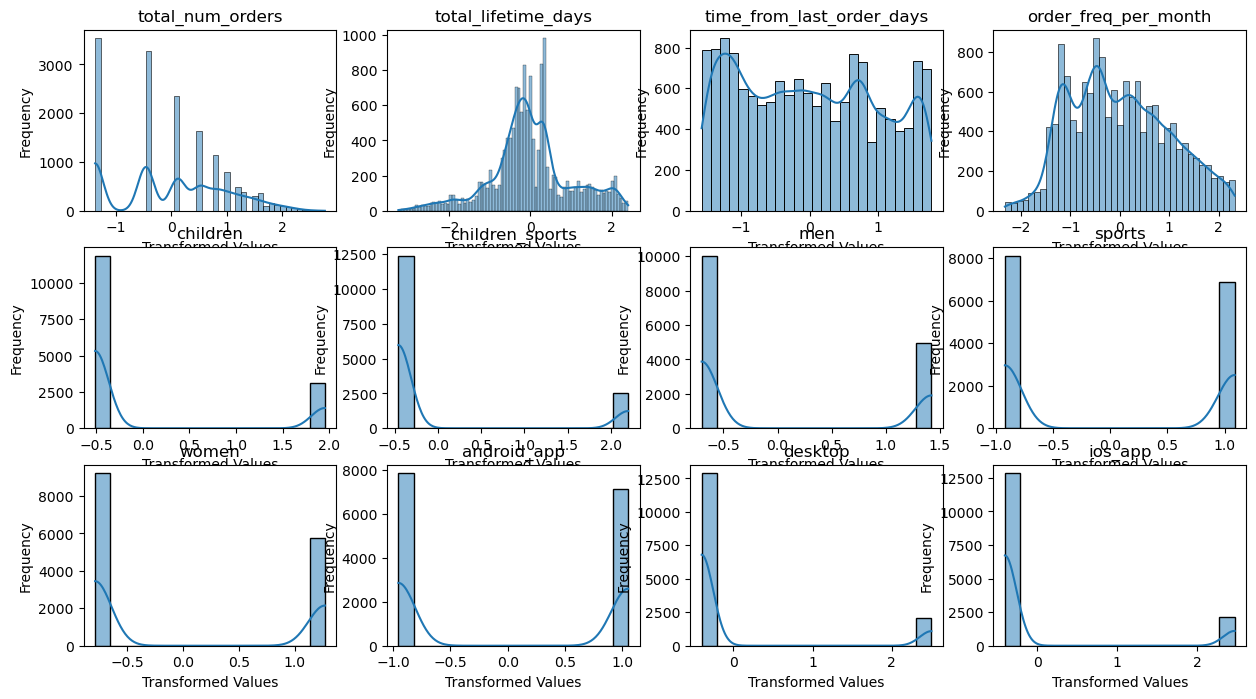

In [33]:
# Get the number of columns in the dataset
num_columns = X_train.shape[1]

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=num_columns // 3, figsize=(15, 8))


axes = axes.flatten()
column_names = X.columns


# Iterate through columns and plot histograms
for i in range(num_columns):
    sns.histplot(X_train[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'{column_names[i]}')
    axes[i].set_xlabel('Transformed Values')
    axes[i].set_ylabel('Frequency')

plt.tight_layout(pad=2.5)
plt.show()

In [ ]:
y_scaler = pt.fit(y_train)

y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [ ]:
plt.figure(figsize=(4, 2))

# Plot the transformed distribution
sns.histplot(y_train, kde=True)
plt.title('Transformed - y_train')

plt.show()

In [ ]:
lm = LinearRegression()

model = lm.fit(X_train, y_train)

In [ ]:
## Test model results

y_pred = model.predict(X_test)

y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)


y_pred = y_pred.rename(columns={0: "y_pred"})
y_test = y_test.rename(columns={0: "y_test"})


r_df = pd.concat([y_test, y_pred], axis=1)

r_df['residual'] = r_df['y_test']-r_df['y_pred']

r_df

In [ ]:
## Training model reslults 

y_train_pred = model.predict(X_train)

y_train_pred = pd.DataFrame(y_train_pred)
y_train = pd.DataFrame(y_train)

y_train_pred = y_train_pred.rename(columns={0: "y_train_pred"})
y_train = y_train.rename(columns={0: "y_train"})


r_train_df = pd.concat([y_train, y_train_pred], axis=1)

r_train_df['residuals'] = r_train_df['y_train'] - r_train_df['y_train_pred']

r_train_df

In [ ]:
RMSE = np.sqrt(mse(y_test, y_pred))
MAE = mae(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

print(f'\nModel Interpretation Test:\n{"*"*26}\nMAE:{MAE}\nRMSE: {RMSE}\nR2: {round(R2,10)}')

RMSE_train = np.sqrt(mse(y_train, y_train_pred))
MAE_train = mae(y_train, y_train_pred)
R2_train = r2_score(y_train, y_train_pred)

print(f'\nModel Interpretation Train:\n{"*"*26}\nMAE:{MAE_train}\nRMSE: {RMSE_train}\nR2: {round(R2_train,10)}')

In [ ]:
# Calculate R-squared
r_squared = r2_score(r_df['y_test'], r_df['y_pred'])

# Set up the figure for the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot with linear fit line
sns.regplot(x='y_test', y='y_pred', data=r_df, scatter_kws={'s': 20}, line_kws={'color': 'green'})
plt.title(f'Scatter Plot of Predicted vs. Actual (R-squared={r_squared:.4f})')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')

plt.show()